tgb - 8/5/2019 - Exploring how to:  
- Separate a Landau potential for both precipitable water and MSE  
- Relate it to effective surface tension of the moist/dry contour

In [4]:
import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
import datetime
from skimage import measure
from scipy import ndimage
import scipy.integrate as sin 

In [5]:
import Landau_Potential_Diffusion

# 1) Standard RCE 300K simulation

In [6]:
path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_206x206/output/'

In [7]:
RCE300 = xr.open_mfdataset(path+'lfff[0-6]???????.nc')

/users/jwindmil/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/jwindmil/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [8]:
RCE300

<xarray.Dataset>
Dimensions:       (bnds: 2, level1: 75, rlat: 206, rlon: 206, soil1: 10, srlat: 206, srlon: 206, time: 1680)
Coordinates:
  * rlon          (rlon) float32 0.0 0.03 0.06 ... 6.0899997 6.12 6.15
  * rlat          (rlat) float32 0.0 0.03 0.06 ... 6.0899997 6.12 6.15
  * srlon         (srlon) float32 0.015 0.044999998 ... 6.1349998 6.165
  * srlat         (srlat) float32 0.015 0.044999998 ... 6.1349998 6.165
    lon           (rlat, rlon) float32 -5.008956e-06 0.029994989 ... 6.149995
    lat           (rlat, rlon) float32 -2.504478e-06 ... 6.1499977
    height_2m     float32 2.0
    height_toa    float32 33250.0
  * soil1         (soil1) float32 0.005 0.025 0.07 0.16 ... 1.47 2.86 5.74 11.5
  * time          (time) datetime64[ns] 2011-07-12T12:00:00 ... 2011-09-20T11:00:00
Dimensions without coordinates: bnds, level1
Data variables:
    time_bnds     (time, bnds) datetime64[ns] dask.array<shape=(1680, 2), chunksize=(1, 2)>
    rotated_pole  (time) |S1 b'' b'' b'' b'' b'' 

# 1.1) Check FMSE and PW budget

In [9]:
dt = 3600; # Timestep in seconds
tcoor = dt*np.arange(0,RCE300.time.shape[0])

### 1.1.1) FMSE

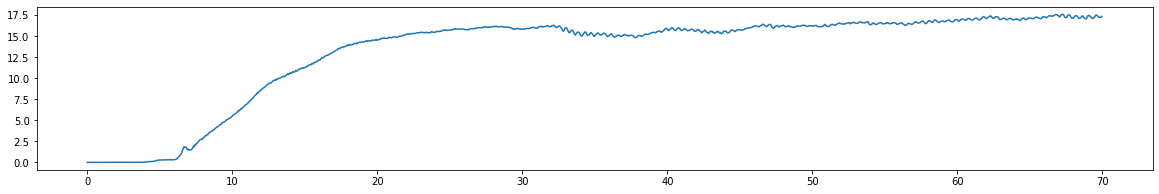

In [10]:
plt.figure(figsize=(20,3))

plt.plot(tcoor/(24*3600),RCE300.TQV.std(dim=['rlon','rlat']))

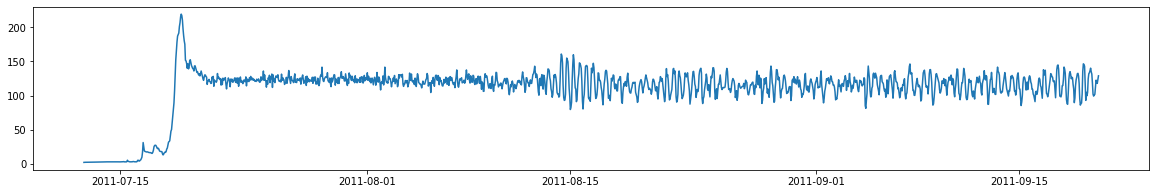

In [11]:
SEF = -RCE300.SHFL_S - RCE300.LHFL_S
plt.figure(figsize=(20,3))
plt.plot(RCE300.time,SEF.mean(dim=['rlon','rlat']))

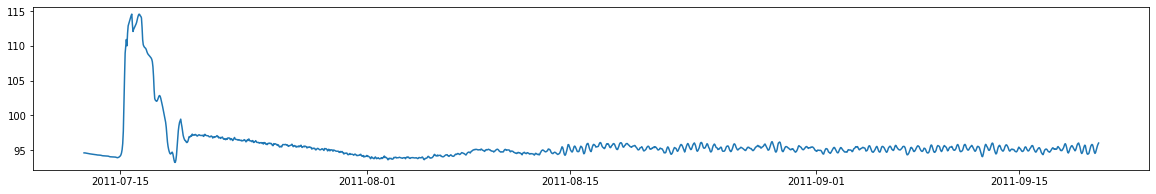

In [12]:
SW = RCE300.ASOB_T-RCE300.ASOB_S
plt.figure(figsize=(20,3))
plt.plot(RCE300.time,SW.mean(dim=['rlon','rlat']))

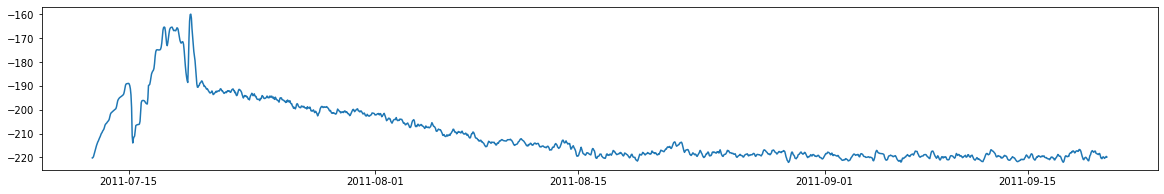

In [13]:
LW = RCE300.ATHB_T-RCE300.ATHB_S;
plt.figure(figsize=(20,3))
plt.plot(RCE300.time,LW.mean(dim=['rlon','rlat']))

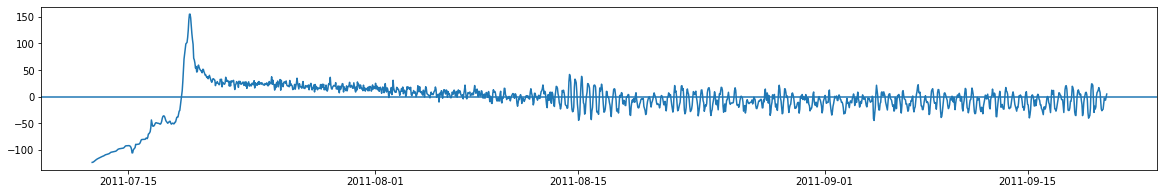

In [14]:
DIAB = LW+SW+SEF
plt.figure(figsize=(20,3))
plt.plot(RCE300.time,DIAB.mean(dim=['rlon','rlat']))
plt.axhline(y=0)

In [15]:


t_range = np.arange(0,np.size(RCE300.time)-2)
dMSE_dt = (RCE300.FMSE.values[t_range+2,:,:]-RCE300.FMSE.values[t_range,:,:])/(2*dt)

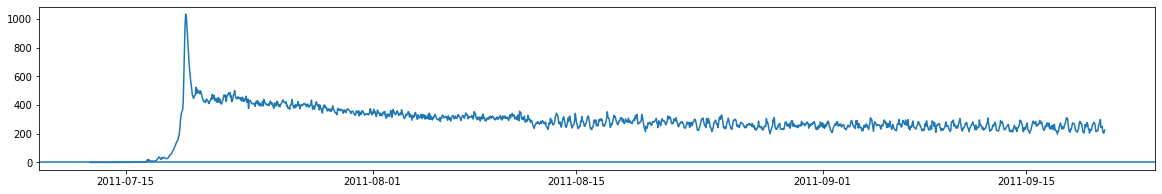

In [16]:
plt.figure(figsize=(20,3))
plt.plot(RCE300.time[1:-1],dMSE_dt.std(axis=(1,2)))
plt.axhline(y=0)

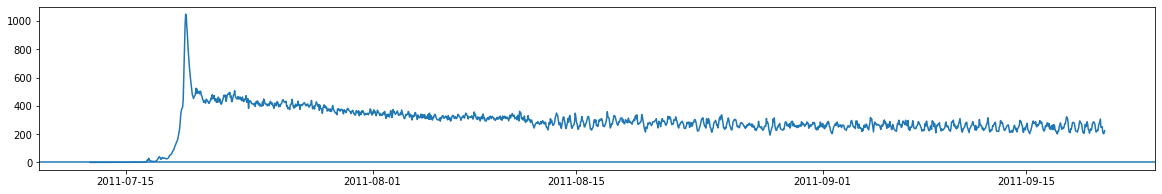

In [17]:
ADV_MSE = dMSE_dt-DIAB[1:-1]
plt.figure(figsize=(20,3))
plt.plot(RCE300.time[1:-1],ADV_MSE.std(axis=(1,2)))
plt.axhline(y=0)

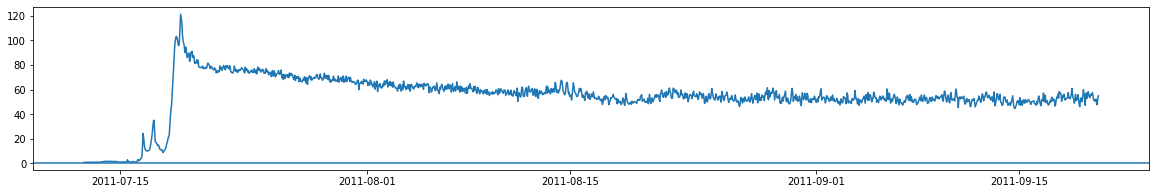

In [18]:
plt.figure(figsize=(20,3))
plt.plot(RCE300.time,DIAB.std(axis=(1,2)))
plt.axhline(y=0)

-39178228.0
<xarray.DataArray 'FMSE' ()>
dask.array<shape=(), dtype=float32, chunksize=()>
Coordinates:
    height_2m   float32 2.0
    height_toa  float32 33250.0


Text(0.5, 1.0, 'Diff')

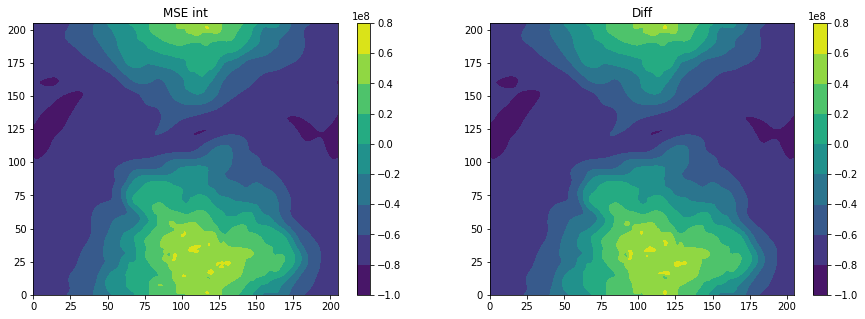

In [19]:
# Test if we can integrate the derivative back to the full MSE
MSE_int = np.sum(dMSE_dt,axis=0)*dt
print(MSE_int.mean(axis=(0,1)))
DIFF = RCE300.FMSE[-2,:,:]-RCE300.FMSE[1,:,:]
print(DIFF.mean(axis=(0,1)))

plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
plt.contourf(MSE_int)
plt.colorbar()
plt.title('MSE int')

ax2 = plt.subplot(122)
plt.contourf(DIFF)
plt.colorbar()
plt.title('Diff')

### 1.1.2) PW

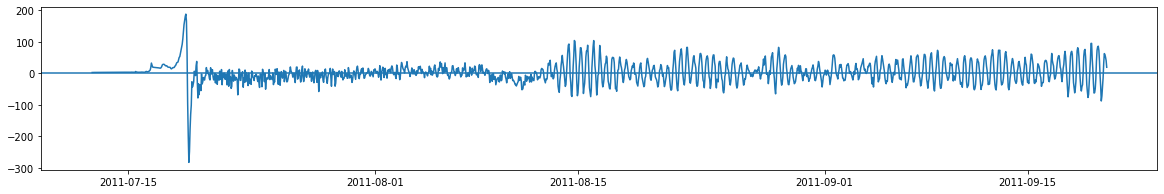

In [20]:
L_V = 2.501e6 # Latent heat of vaporization of water
E_P = -RCE300.LHFL_S-L_V*RCE300.TOT_PR
plt.figure(figsize=(20,3))
plt.plot(RCE300.time,E_P.mean(dim=['rlon','rlat']))
plt.axhline(y=0)

In [21]:
dt = 3600; # Timestep in seconds
t_range = np.arange(0,np.size(RCE300.time)-2)
dPW_dt = (RCE300.TQV.values[t_range+2,:,:]-RCE300.TQV.values[t_range,:,:])/(2*dt)

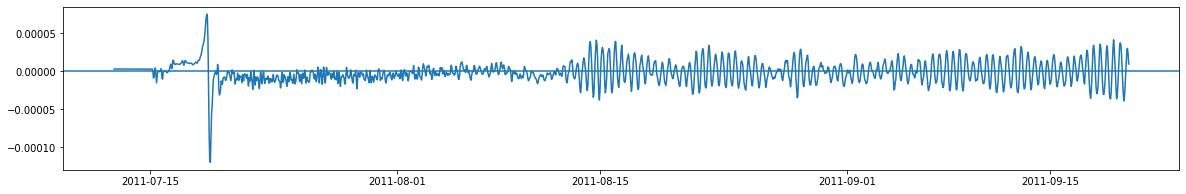

In [22]:
plt.figure(figsize=(20,3))
plt.plot(RCE300.time[1:-1],dPW_dt.mean(axis=(1,2)))
plt.axhline(y=0)

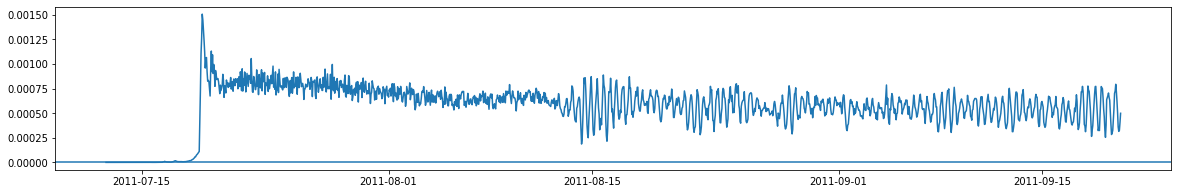

In [23]:
ADV_PW = dPW_dt-E_P[1:-1]/L_V
plt.figure(figsize=(20,3))
plt.plot(RCE300.time[1:-1],ADV_PW.std(axis=(1,2)))
plt.axhline(y=0)

## 1.2) Construct potential

### 1.2.1) FMSE

In [24]:
# Select time period over which to calculate the potential
iT = np.arange(24*50,24*51,1)
TiT = tcoor[iT]

In [25]:
field_hist, bin_edges = np.histogram(RCE300.FMSE[iT,:,:].values.flatten(),bins=30)
bin_mid = 0.5*(bin_edges[:-1]+bin_edges[1:])

In [26]:
field_hist

array([ 33575,  92053, 152976, 103496,  90287,  57167,  42117,  35710,
        32020,  32452,  31699,  31075,  29682,  27464,  25913,  24478,
        22151,  19763,  16695,  14814,  12954,  11722,  12009,  14056,
        18471,  21632,   9177,   2341,    467,     48])

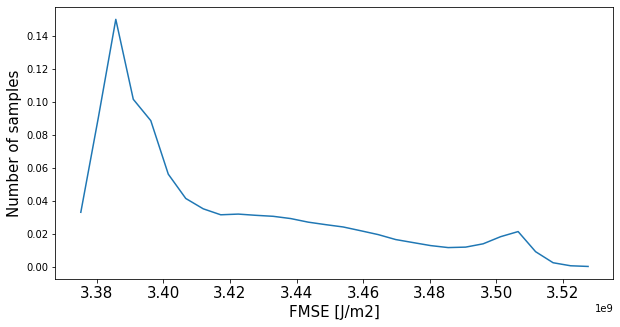

In [27]:
fz = 15

plt.figure(figsize=(10,5))

ax = plt.subplot(111)
ax.plot(bin_mid,field_hist/np.sum(field_hist))
plt.xlabel('FMSE [J/m2]',fontsize=fz)
plt.ylabel('Number of samples',fontsize=fz)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz) 

In [28]:
FMSE_min = RCE300.FMSE.min().values
FMSE_max = RCE300.FMSE.max().values

In [29]:
# Calculate histogram for each day

day_range = range(1,69)
fmse_bins = np.linspace(FMSE_min, FMSE_max, num = 30)
fmse_bin_mid = 0.5*(fmse_bins[:-1]+fmse_bins[1:])
delta_fmse_bin = fmse_bins[1] - fmse_bins[0]

fmse_hist_2D = np.ones((len(day_range), len(fmse_bin_mid)))

for i_d, day in enumerate(day_range): 
    iT_d = np.arange(24*day,24*(day+1),1)
    field_hist, bin_edges = np.histogram(RCE300.FMSE[iT_d,:,:].values.flatten(),bins=fmse_bins, density = True)
    fmse_hist_2D[i_d, :] = field_hist

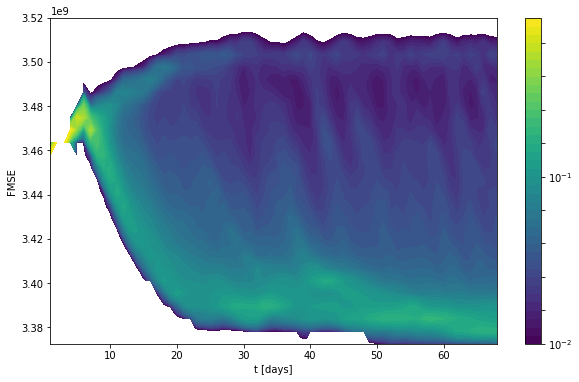

In [30]:
plt.figure(figsize = (10, 6))

# Use logarithmic colormap
lev_exp = np.arange(-2, 0.0, 0.05)
levs = np.power(10.0, lev_exp)

plt.contourf(day_range, fmse_bin_mid, np.ma.masked_where(fmse_hist_2D <= 0, fmse_hist_2D).T*delta_fmse_bin, levs, norm=colors.LogNorm())
plt.xlabel('t [days]')
plt.ylabel('FMSE')

plt.ylim(ymax = 3.52e9)
plt.colorbar()

In [31]:
# From https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-np
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- np ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [32]:
# Make function to calculate conditional mean and std
# We condition field_y on field_x
def conditional_avg_and_std(bin_edges,field_x,field_y):
    # Initialization
    Nbin = np.size(bin_edges)
    Ym = np.zeros((Nbin-1,1))
    Ystd = np.copy(Ym)

    for ibin,edge in enumerate(bin_edges):
        print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
        if ibin>0:
            w = (field_x>=edge_left)*(field_x<edge)
            Ym[ibin-1],Ystd[ibin-1] = weighted_avg_and_std(field_y,w)

        edge_left = edge
    
    return Ym,Ystd

In [33]:
def potential(order_parameter,forcing,Nbins=30):
    # Takes: Order parameter, Forcing in time, Number of bins
    # Returns: bin_mid [middle of bins], Potential, conditional mean (forcing), conditional std (forcing)
    order_hist,bin_edges = np.histogram(order_parameter.values.flatten(),bins=Nbins)
    bin_mid = 0.5*(bin_edges[:-1]+bin_edges[1:])
    forcing_m,forcing_std = conditional_avg_and_std(bin_edges,\
                                                    order_parameter,\
                                                    forcing)
    Vm = -sin.cumtrapz(forcing_m,x=bin_mid,axis=0)
    return bin_mid,np.concatenate((np.zeros((1,1)),Vm),axis=0),forcing_m,forcing_std

In [34]:
binm,Vm,diabm,diabstd = potential(RCE300.FMSE[iT,:,:],DIAB[iT,:,:])

In [35]:
DIABm,DIABstd = conditional_avg_and_std(bin_edges,RCE300.FMSE[iT,:,:],DIAB[iT,:,:])

ValueError: x and y must have same first dimension, but have shapes (30,) and (29, 1)

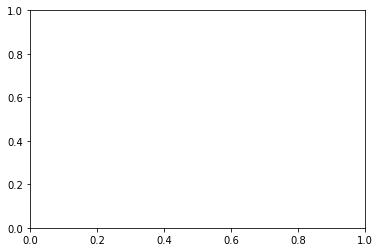

In [36]:
plt.plot(bin_mid,DIABm)
plt.axhline(y=0)
plt.xlabel('FMSE [J/m2]')
plt.ylabel('Diabatic heating [W/m2]')

In [ ]:
Vm = -sin.cumtrapz(DIABm,x=bin_mid,axis=0)
Vm = np.concatenate((np.zeros((1,1)),Vm),axis=0)

In [ ]:
scale = np.max(np.abs(Vm))/np.max(field_hist)

plt.figure(figsize=(5,5))
plt.plot(bin_mid,Vm,color='k',linewidth=2,label='V')
plt.plot(bin_mid,Vm[:,0]+field_hist*scale/2,label='PDF FMSE')
plt.ylabel('Potential',fontsize=fz)
plt.xlabel('FMSE [J/m2]',fontsize=fz)
plt.legend(fontsize=fz)

### 1.2.2) PW

In [ ]:
field_hist,bin_edges = np.histogram(RCE300.TQV[iT,:,:].values.flatten(),bins=30)
bin_mid = 0.5*(bin_edges[:-1]+bin_edges[1:])

In [ ]:
field_hist

In [ ]:
fz = 15

plt.figure(figsize=(10,5))

ax = plt.subplot(111)
ax.plot(bin_mid,field_hist/np.sum(field_hist))
plt.xlabel('PW [kg/m2]',fontsize=fz)
plt.ylabel('Number of samples',fontsize=fz)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz) 

In [ ]:
EPm,EPstd = conditional_avg_and_std(bin_edges,RCE300.TQV[iT,:,:],E_P[iT,:,:])

In [ ]:
plt.plot(bin_mid[:-3],EPm[:-3])
plt.axhline(y=0)
plt.xlabel('PW [kg/m2]')
plt.ylabel('Evaporation - Precipitation [W/m2]')

In [ ]:
Vm = -sin.cumtrapz(EPm,x=bin_mid,axis=0)
Vm = np.concatenate((np.zeros((1,1)),Vm),axis=0)

In [ ]:
scale = np.max(np.abs(Vm[:-3]))/np.max(field_hist)

plt.figure(figsize=(5,5))
plt.plot(bin_mid[:-3],Vm[:-3],color='k',linewidth=2,label='V')
plt.plot(bin_mid[:-3],Vm[:-3,0]+field_hist[:-3]*scale/2,label='PDF PW')
plt.ylabel('Potential',fontsize=fz)
plt.xlabel('PW [kg/m2]',fontsize=fz)
plt.legend(fontsize=fz)

## 1.3) Estimate diffusion coefficient

In [ ]:
m_lon = 111e3; # Conversion from degree to meters used in simulation
x = m_lon*RCE300.rlon
y = m_lon*RCE300.rlat

In [ ]:
# Defining the wavenumber as (2*pi)/wavelength here
dx = x[2]-x[1]; Nx = np.size(x);
k = np.arange(start=0,stop=(2*np.pi)/(2*dx),step=(2*np.pi)/(Nx*dx)); Nk = np.size(k);

dy = y[2]-y[1]; Ny = np.size(y);
l = np.arange(start=0,stop=(2*np.pi)/(2*dy),step=(2*np.pi)/(Ny*dy)); Nl = np.size(l);

kmod = np.zeros((Nk-2,Nl-2))
for i in range(Nk-2):
    for j in range(Nl-2):
        kmod[i,j] = (k[i+1]**2+l[j+1]**2)**0.5
        
dok = np.arange(1,Nk-1); dol = np.arange(1,Nl-1); # Index restriction for 2D FFT

### 1.3.1) FMSE

In [ ]:
# Select time period over which to calculate the potential
iT = np.arange(24*60,24*69,1)
TiT = tcoor[iT]

In [ ]:
FFT_advMSE = fft.fft2(ADV_MSE[iT,:,:])
FFT_MSE = fft.fft2(RCE300.FMSE[iT,:,:])

In [ ]:
def Octave_var(kmod,var):

    ik = np.arange(0,np.size(kmod)); KM = kmod.flatten();
    koct_min = np.int(np.floor(np.log2(KM[ik[0]]))); 
    koct_max = np.int(np.ceil(np.log2(KM[ik[-1]]))); 
    koct = np.zeros((koct_max-koct_min,1));

    S = var.shape; 
    varoct = np.zeros((S[0],koct_max-koct_min));
    for i_koct in range(koct_min,koct_max):
        print('k octave is',i_koct,'and k index is',i_koct-koct_min)
        ind = (np.log2(KM)>=(i_koct-1) * (np.log2(KM)<i_koct));
        R = np.reshape(var,newshape=(S[0],S[1]*S[2]));
        if np.size(ind)>1: 
            varoct[:,i_koct-koct_min] = np.mean(R[:,ind],axis=1);
            koct[i_koct-koct_min] = np.mean(KM[ind]);
        else:
            varoct[:,i_koct-koct_min] = R[:,ind];
            koct[imin] = KM[ind];
            
    return koct,varoct

In [ ]:
var = np.real(FFT_advMSE*np.conj(FFT_advMSE))[:,dok,:][:,:,dol]
koct,varoct = Octave_var(kmod,var)

In [ ]:
fz = 15
KM = kmod.flatten()

plt.figure(figsize=(15,5))
plt.scatter(np.log10(KM),np.log10(np.mean(var,axis=0).flatten()))
plt.scatter(np.log10(koct),np.log10(np.mean(varoct,axis=0)),color='k')

plt.title('MSE advection spectrum',fontsize=fz)
plt.xlabel('log10 |k| [1/m]',fontsize=fz)
plt.ylabel('log10 |Power spectrum|',fontsize=fz)

In [ ]:
var = np.real(FFT_MSE*np.conj(FFT_MSE))[:,dok,:][:,:,dol]
koct,varoct = Octave_var(kmod,var)

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(np.log10(KM),np.log10(np.mean(var,axis=0).flatten()))
plt.scatter(np.log10(koct),np.log10(np.mean(varoct,axis=0)),color='k')

plt.title('MSE',fontsize=fz)
plt.xlabel('log10 |k| [1/m]',fontsize=fz)
plt.ylabel('log10 |Power spectrum|',fontsize=fz)

In [ ]:
# Transfer function from MSE to advection(MSE)
Tadv = FFT_advMSE/FFT_MSE
Tadv_mod = np.absolute(Tadv)

In [ ]:
var = Tadv_mod[:,dok,:][:,:,dol]

In [ ]:
X = np.log10(KM)
Y = np.log10(np.mean(var,axis=0).flatten())

plt.figure
plt.scatter(X,Y)

plt.title('Modulus transfer fx MSE=>(MSE advection)',fontsize=fz)
plt.xlabel('log10 |k| [1/m]',fontsize=fz)
plt.ylabel('log10 |Amplitude|',fontsize=fz)

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
def func(x, a):
    return 2*x+a

In [ ]:
LIM = [-4.5,-4.25,-4,-3.75,-3.5,-3.25]
popt = np.zeros((np.size(LIM)))
pcov = np.copy(popt)
perr = np.copy(popt)

for i,lim in enumerate(LIM):
    print('i=',i,'& lim=',lim)
    popt[i], pcov[i] = curve_fit(func, X[X<lim], Y[X<lim])
    perr[i] = np.sqrt(pcov[i])
print('popt=',popt)
print('pcov=',pcov)
print('error=',perr)

In [ ]:
X = np.log10(KM)
#X = np.log10(2*np.pi/KM)
plt.figure(figsize=(15,5))
plt.scatter(X,np.log10(np.mean(var,axis=0).flatten()),color='k')
for i,lim in enumerate(LIM):
    plt.plot(X,2*X+popt[i],label='D='+'%.0e'%(10**popt[i])+' m2/s')
    
plt.title('Modulus transfer fx MSE=>(MSE advection)',fontsize=fz)
plt.xlabel('log10 |k| [1/m]',fontsize=fz)
plt.ylabel('log10 |Amplitude|',fontsize=fz)
plt.legend(fontsize=fz)

In [ ]:
def wavenumbers(x,y):
    # Takes x,y
    # Returns k,l,|k|,lambda,k(extended),l(extended),|k|(extended)
    dx = x[2]-x[1]; Nx = np.size(x);
    dy = y[2]-y[1]; Ny = np.size(y);
    
    k = np.arange(start=0,stop=(2*np.pi)/(2*dx),step=(2*np.pi)/(Nx*dx)); Nk = np.size(k);
    l = np.arange(start=0,stop=(2*np.pi)/(2*dy),step=(2*np.pi)/(Ny*dy)); Nl = np.size(l);
    
    kmod = np.zeros((Nk-2,Nl-2))
    for i in range(Nk-2):
        for j in range(Nl-2):
            kmod[i,j] = (k[i+1]**2+l[j+1]**2)**0.5
            
    # Extended wavenumbers to convert back to physical space
    kext = np.concatenate((k,k[::-1]))
    lext = np.concatenate((l,l[::-1]))
    
    kmod_ext = np.zeros((Nx,Ny))
    for i in range(Nx):
        for j in range(Ny):
            kmod_ext[i,j] = (kext[i]**2+lext[j]**2)**0.5
            
    return k,l,kmod,2*np.pi*np.sqrt(2)/kmod,kext,lext,kmod_ext

In [ ]:
np.log10(kmod[1])

In [ ]:
np.log10(KM[1])

In [ ]:
LIM_MIN = np.floor(2*np.log10(KM[1]))/2

In [ ]:
def pick_diffusivity(x,y,field,field_adv):
    
    def func(x, a):
        return 2*x+a
    
    # Define wavenumbers
    k,l,kmod,lam = wavenumbers(x,y)
    KM = kmod.flatten()
    dok = np.arange(1,Nk-1); dol = np.arange(1,Nl-1); # Index restriction for 2D FFT
    
    # Fourier transform the fields
    FFT_adv = fft.fft2(field_adv)
    FFT = fft.fft2(field)
    
    # Calculate transfer function, its modulus and phase
    T = (FFT_adv/FFT)[:,dok,:][:,:,dol]
    Tabs = np.absolute(T)
    Tpha = np.angle(T)
    
    # Fit a line to the modulus graph for different intervals
    X = np.log10(KM); Y = np.log10(np.mean(Tabs,axis=0).flatten())
    LIM_MIN = np.ceil(4*X[1])/4
    LIM_MAX = np.floor(4*X[-1])/4
    LIM = np.arange(LIM_MIN,LIM_MAX,0.25) # Intervals to test
    
    # Initialization
    popt = np.zeros((np.size(LIM)))
    pcov = np.copy(popt); perr = np.copy(popt)
    
    # Fit
    for i,lim in enumerate(LIM):
        popt[i], pcov[i] = curve_fit(func, X[X<lim], Y[X<lim])
        perr[i] = np.sqrt(pcov[i])
        
    # Plot magnitude and phase of transfer function
    plt.figure(figsize=(15,7.5))
    plt.subplot(2,1,1)
    plt.scatter(X,Y,color='k')
    for i,lim in enumerate(LIM):
        plt.plot(X,func(X,popt[i]),label='D='+'%.0e'%(10**popt[i])+' m2/s')
    plt.title('Modulus transfer fx MSE=>(MSE advection)',fontsize=fz)
    plt.xlabel('log10 |k| [1/m]',fontsize=fz)
    plt.ylabel('log10 |Amplitude|',fontsize=fz)
    plt.legend(fontsize=fz)
    plt.subplot(2,1,2)
    plt.scatter(X,np.cos(Tpha).mean(axis=0).flatten(),color='k')
    plt.title('Phase transfer fx MSE=>(MSE advection)',fontsize=fz)
    plt.xlabel('log10 |k| [1/m]',fontsize=fz)
    plt.ylabel('cos(phase)',fontsize=fz)
    
    return kmod,10**popt

In [ ]:
kmod,D = pick_diffusivity(x,y,RCE300.FMSE[iT,:,:],ADV_MSE[iT,:,:])

tgb - 8/8/2019 - New way of extracting diffusivity based on its contribution to MSE variance

In [ ]:
k,l,kmod,lam = wavenumbers(x,y)
KM = kmod.flatten()
dok = np.arange(1,Nk-1); dol = np.arange(1,Nl-1); # Index restriction for 2D FFT

# Fourier transform the fields
FFT_adv = fft.fft2(ADV_MSE[iT,:,:])
FFT = fft.fft2(RCE300.FMSE[iT,:,:])

In [ ]:
X = np.log10(KM)
Y = KM**2*np.mean(np.real(np.conj(FFT_adv)*FFT)[:,dok,:][:,:,dol],axis=0).flatten()

plt.figure(figsize=(15,5))
plt.axhline(y=0,color='b')
plt.scatter(X[Y<0],Y[Y<0],color='g')
plt.scatter(X[Y>0],Y[Y>0],color='k')
plt.title('|k|^2*Co-spectrum (Adv,MSE)',fontsize=fz)
plt.xlabel('log10 |k| [1/m]',fontsize=fz)
plt.ylabel('Amplitude',fontsize=fz)
plt.legend(fontsize=fz)

In [ ]:
NUM = np.mean(np.real(np.conj(FFT_adv)*FFT)[:,dok,:][:,:,dol],axis=0).flatten()
# Net variance from negative part of advection
INT = sin.trapz(x=KM[NUM<0],y=NUM[NUM<0])

In [ ]:
DEN = KM**2*np.mean(np.real(np.conj(FFT)*FFT)[:,dok,:][:,:,dol],axis=0).flatten()
INT2 = sin.trapz(x=KM,y=DEN)

In [ ]:
D = -INT/INT2
print(D)

In [ ]:
X = np.log10(KM)
Y = KM**2*np.mean(np.real(np.conj(FFT_adv)*FFT)[:,dok,:][:,:,dol],axis=0).flatten()

DIF = -KM**4*D*np.mean(np.real(np.conj(FFT)*FFT)[:,dok,:][:,:,dol],axis=0).flatten()
REST = Y-DIF

plt.figure(figsize=(15,5))
plt.axhline(y=0,color='b')
plt.scatter(X[Y<0],Y[Y<0],color='g')
plt.scatter(X[Y>0],Y[Y>0],color='k')
plt.scatter(X,DIF,color='r')
plt.scatter(X,REST,color='c')
plt.title('|k|^2*Co-spectrum (Adv,MSE)',fontsize=fz)
plt.xlabel('log10 |k| [1/m]',fontsize=fz)
plt.ylabel('Amplitude',fontsize=fz)
plt.ylim((-4e6,4e6))
plt.legend(fontsize=fz)

In [ ]:
INT_DIF = sin.trapz(x=KM,y=-D*(KM**2)*np.mean(np.real(np.conj(FFT)*FFT)[:,dok,:][:,:,dol],axis=0).flatten())

In [ ]:
INT_DIF

In [ ]:
INT = sin.trapz(x=KM[NUM<0],y=NUM[NUM<0])
INT2 = sin.trapz(x=KM,y=NUM)
print("%0.3e"%INT,"%0.3e"%INT2)

tgb - Last step is to convert back to physical space

In [ ]:
# Define more extended wavenumbers for converting back
# Defining the wavenumber as (2*pi)/wavelength here
dx = x[2]-x[1]; Nx = np.size(x);
k = np.arange(start=0,stop=(2*np.pi)/(2*dx),step=(2*np.pi)/(Nx*dx)); Nk = np.size(k);
kext = np.concatenate((k,k[::-1]))

dy = y[2]-y[1]; Ny = np.size(y);
l = np.arange(start=0,stop=(2*np.pi)/(2*dy),step=(2*np.pi)/(Ny*dy)); Nl = np.size(l);
lext = np.concatenate((l,l[::-1]))

kmod = np.zeros((Nk-2,Nl-2))
for i in range(Nk-2):
    for j in range(Nl-2):
        kmod[i,j] = (k[i+1]**2+l[j+1]**2)**0.5

kmod_ext = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        kmod_ext[i,j] = (kext[i]**2+lext[j]**2)**0.5

In [ ]:
def dif_from_smoothing(x,y,field,field_adv):
    # Takes: Coordinates(x,y),order parameter,advection field
    # Returns: Effective diffusion(m2/s),diffusion field
    
    # Define wavenumbers
    k,l,kmod,lam,kext,lext,kmodext = wavenumbers(x,y)
    KM = kmod.flatten()
    dok = np.arange(1,Nk-1); dol = np.arange(1,Nl-1); # Index restriction for 2D FFT
    
    # Fourier transform the fields
    FFT_adv = fft.fft2(field_adv)
    FFT = fft.fft2(field)
    
    # Calculate diffusivity(t) from variance injection from advection
    # Fits diffusivity so that it smoothes total variance at the same rate
    S = field.shape
    D = np.zeros((S[0],))
    for it in range(S[0]):
        num = np.real(np.conj(FFT_adv[it,:,:])*FFT[it,:,:])[dok,:][:,dol].flatten()
        NUM = sin.trapz(x=KM[num<0],y=num[num<0])
        den = (KM**2)*np.real(np.conj(FFT[it,:,:])*FFT[it,:,:])[dok,:][:,dol].flatten()
        DEN = sin.trapz(x=KM,y=den)
        D[it] = -NUM/DEN
    
    # Transforms diffusion back into physical space
    field_dif = -np.real(fft.ifft2(np.moveaxis(np.tile(D,(S[1],S[2],1)),2,0)*\
                                   np.tile((kmod_ext**2),(S[0],1,1))*FFT))
    
    # Activate test if you would like to calculate the advection
    # residual in spectral space rather than in physical space
#     field_adv_test = np.real(fft.ifft2(FFT_adv+np.moveaxis(np.tile(D,(S[1],S[2],1)),2,0)*\
#                                    np.tile((kmod_ext**2),(S[0],1,1))*FFT))
    
    return D,field_dif

In [ ]:
DIF_MSE.shape

In [ ]:
binm,Vm,difm,difstd = potential(RCE300.FMSE[iT,:,:],DIF_MSE)

In [ ]:
binm,Vresm,resm,resstd = potential(RCE300.FMSE[iT,:,:],ADV_MSE[iT,:,:]-DIF_MSE)

In [ ]:
ADV_TEST.shape

In [ ]:
binm,Vtestm,testm,teststd = potential(RCE300.FMSE[iT,:,:],ADV_TEST[:,:,:])

In [ ]:
plt.figure
plt.plot(binm,Vm,label='dif')
plt.plot(binm,Vresm,label='res')
plt.plot(binm,Vtestm,label='test')
plt.plot(binm,Vdiab+Vresm,label='tot')
plt.ylim((-3.5e9,2e9))
plt.legend()

In [ ]:
D,DIF_MSE,ADV_TEST = dif_from_smoothing(x,y,RCE300.FMSE[iT,:,:],ADV_MSE[iT,:,:])

In [ ]:
plt.figure
plt.plot(tcoor[iT],D)

In [ ]:
DIF_MSE = -D*(kmod_ext**2)*FFT

In [ ]:
ADV_RES = FFT_adv-DIF_MSE

In [ ]:
adv.mean(axis=(1,2)).shape

In [ ]:
adv = np.real(fft.ifft2(FFT_adv))
dif = np.real(fft.ifft2(DIF_MSE))
res = np.real(fft.ifft2(ADV_RES))

In [ ]:
plt.plot(ADV_MSE[iT,:,:].std(axis=(1,2)))
plt.plot(adv.std(axis=(1,2)))
plt.plot(dif.std(axis=(1,2)),label='dif')
plt.plot(res.std(axis=(1,2)))

plt.legend()

In [ ]:
binm,Vm,difm,difstd = potential(RCE300.FMSE[iT,:,:],dif)

In [ ]:
binm,Vresm,resm,resstd = potential(RCE300.FMSE[iT,:,:],res)

In [ ]:
binm,Vadvm,advm,advstd = potential(RCE300.FMSE[iT,:,:],ADV_MSE[iT,:,:])

In [ ]:
binm,Vdiab,diabm,diabstd = potential(RCE300.FMSE[iT,:,:],DIAB[iT,:,:])

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(binm,difm,color='g')
plt.plot(binm,resm,color='r')
plt.plot(binm,advm,color='b')

In [ ]:
Vtot = Vresm+Vdiab;

plt.figure(figsize=(10,8))
plt.plot(binm,Vm,color='g',label='diffusion')
plt.plot(binm,Vresm,color='r',label='adv residual')
plt.plot(binm,Vadvm,color='b',label='adv total')
plt.plot(binm,Vdiab,color='k',label='diabatic')
plt.plot(binm,Vtot,color='c',label='residual+diabatic')
plt.ylim((-2.5e9,1e9))
plt.legend(fontsize=15)

In [ ]:
scale = np.max(np.abs(Vtot[:-3]))/np.max(field_hist)

plt.figure(figsize=(5,5))
plt.plot(bin_mid[:-3],Vtot[:-3],color='k',linewidth=2,label='V')
plt.plot(bin_mid[:-3],field_hist[:-3]*scale/2,label='PDF FMSE')
plt.ylabel('Potential',fontsize=fz)
plt.xlabel('FMSE [J/m2]',fontsize=fz)
plt.legend(fontsize=fz)

In [ ]:
field_hist,bin_edges = np.histogram(RCE300.FMSE[iT,:,:].values.flatten(),bins=30)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(binm,field_hist)

### Auto-correlation scale

In [ ]:
MSE_auto = np.real(fft.fftshift(fft.ifft2(np.real(FFT_MSE*np.conj(FFT_MSE)))))

In [ ]:
plt.imshow(MSE_auto[0,:,:])
plt.colorbar()

tgb - Define coordinate change between Cartesian and polar  
https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates

In [ ]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

tgb - Average auto-correlation field over each radius

In [ ]:
x = dx.values*np.arange(-Nx/2+0.5,Nx/2+0.5)
y = dy.values*np.arange(-Ny/2+0.5,Ny/2+0.5)
xx,yy = np.meshgrid(x,y)
rho,theta = cart2pol(xx,yy)

In [ ]:
plt.imshow(rho/1e3)
#plt.imshow(theta)
plt.colorbar()

In [ ]:
uniR,uniR_ind = np.unique(rho,return_inverse=True)
MSE_aut1 = np.zeros((np.size(uniR),))
Rad = np.copy(MSE_aut1)

for i,R in enumerate(uniR):
    MSE_aut1[i] = MSE_auto[0,:,:].flatten()[uniR_ind==i].mean()
    Rad[i] = R

In [ ]:
plt.figure
plt.plot(Rad,MSE_aut1)

In [ ]:
np.mean(Rad)

In [ ]:
def func(x0,a,b,c,d,e):
    x = x0/1e5
    return 1e23*(a*x**4+b*x**3+c*x**2+d*x**1+e)

In [ ]:
popt,pcov = curve_fit(func, Rad, MSE_aut1)

In [ ]:
popt

In [ ]:
plt.figure
plt.plot(Rad,MSE_aut1)
MSE_aut1FIT = func(Rad,popt[0],popt[1],popt[2],popt[3],popt[4])
plt.plot(Rad,MSE_aut1FIT)

In [ ]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [ ]:
idx = nearest_index(MSE_aut1FIT,np.min(MSE_aut1FIT)+(np.max(MSE_aut1FIT)-np.min(MSE_aut1FIT))/np.exp(1))

In [ ]:
Rad[idx]

tgb - 8/6/2019 - Now group everything together in one function

In [ ]:
def autocorrelation_fx(field):
    return np.real(fft.fftshift(fft.ifft2(np.real(fft.fft2(field)*np.conj(fft.fft2(field))))))

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho,phi)

def polargrid(x, y):
    xx,yy = np.meshgrid(x,y)
    return cart2pol(xx,yy)

def autocorrelation_1d(x, y, field):
    # Polar coordinates
    rho,tmp = polargrid(x, y)
    R,R_ind = np.unique(rho,return_inverse=True)
    # Auto-correlation function
    Auto_fx = autocorrelation_fx(field)
    # Initialization
    auto1 = np.zeros((Auto_fx.shape[0],np.size(R)))
    Rad = np.zeros((np.size(R),))
    # Radial average
    for i,r in enumerate(R):
        Rad[i] = r;
        print('Time loop to accumulate autocorrelation over each radius...',end='\r')
        for it in range(Auto_fx.shape[0]):
            auto1[it,i] = Auto_fx[it,:,:].reshape(Auto_fx.shape[1]*Auto_fx.shape[2])[R_ind==i].mean()
    # Return radius and radial average
    return Rad,auto1

def autocorrelation_fit(x, y, field):
    
    def func(x0,a,b,c,d,e):
        x = x0/1e5
        return 1e23*(a*x**4+b*x**3+c*x**2+d*x**1+e)
    
    R,auto = autocorrelation_1d(x, y, field)
    fit = np.zeros((auto.shape[0],R.size))
    print('Time loop to fit autocorrelation with order-4 polynomial...',end='\r')
    for it in range(auto.shape[0]):
        p,pcov = curve_fit(func, R, auto[it,:])
        fit[it,:] = func(R,p[0],p[1],p[2],p[3],p[4])
    return R,fit

def autocorrelation_R(x, y, field):
    
    def nearest_index(array, value):
        idx = (np.abs(array-value)).argmin()
        return idx
    
    R,fit = autocorrelation_fit(x, y, field)
    Rad = np.zeros((fit.shape[0],))
    print('Time loop to find nearest index to max(Autocor)/e...',end='\r')
    for it in range(fit.shape[0]):
        f = fit[it,:]
        idx = nearest_index(f,np.min(f)+(np.max(f)-np.min(f)/np.exp(1)))
        Rad[it] = R[idx]
    print('Done!!                                                     ',end='\r')
    return Rad

In [ ]:
R = np.zeros((1600,))

Rad = autocorrelation_R(x,y,RCE300.FMSE[0:24*60:24,:,:])

In [ ]:
plt.plot(Rad/1e3)

### 1.3.2) PW

In [ ]:
# Select time period over which to calculate the potential
iT = np.arange(24*60,24*69,1)
TiT = tcoor[iT]

In [ ]:
FFT_advPW = fft.fft2(ADV_PW[iT,:,:])
FFT_PW = fft.fft2(RCE300.TQV[iT,:,:])

In [ ]:
# Transfer function from MSE to advection(MSE)
Tadv = FFT_advPW/FFT_PW
Tadv_mod = np.absolute(Tadv)

In [ ]:
var = Tadv_mod[:,dok,:][:,:,dol]

In [ ]:
X = np.log10(KM)
Y = np.log10(np.mean(var,axis=0).flatten())

plt.figure
plt.scatter(X,Y)

plt.title('Modulus transfer fx PW=>(PW advection)',fontsize=fz)
plt.xlabel('log10 |k| [1/m]',fontsize=fz)
plt.ylabel('log10 |Amplitude|',fontsize=fz)

In [ ]:
def func(x, a):
    return 2*x+a

In [ ]:
LIM = [-4.5,-4.25,-4,-3.75,-3.5,-3.25,-3,-2.75]
popt = np.zeros((np.size(LIM)))
pcov = np.copy(popt)
perr = np.copy(popt)

for i,lim in enumerate(LIM):
    print('i=',i,'& lim=',lim)
    popt[i], pcov[i] = curve_fit(func, X[X<lim], Y[X<lim])
    perr[i] = np.sqrt(pcov[i])
print('popt=',popt)
print('pcov=',pcov)
print('error=',perr)

In [ ]:
X = np.log10(KM)
#X = np.log10(2*np.pi/KM)
plt.figure(figsize=(15,5))
plt.scatter(X,np.log10(np.mean(var,axis=0).flatten()),color='k')
for i,lim in enumerate(LIM):
    plt.plot(X,2*X+popt[i],label='D='+'%.0e'%(10**popt[i])+' m2/s')
    
plt.title('Modulus transfer fx PW=>(PW advection)',fontsize=fz)
plt.xlabel('log10 |k| [1/m]',fontsize=fz)
plt.ylabel('log10 |Amplitude|',fontsize=fz)
plt.legend(fontsize=fz)

In [ ]:
kmod,D = pick_diffusivity(x,y,RCE300.TQV[iT,:,:],ADV_PW[iT,:,:])

## 1.4) Consequences of coarsening 
- Auto-correlation length scale    
- Size distribution
- Surface tension
- Landau energy

In [ ]:
ValueError: setting an array element with a sequence.